In [3]:
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import time
import re
import math
from matplotlib import pyplot as plt
import tensorflow as tf
import wandb
from wandb.keras import WandbCallback

path = "/home/andrew/ros_ws/src/2020T1_competition/controller/outerloop_data"
labels = ['00', '01', '02', '10', '11', '12'] # one label representing each combination of foward and turning

In [2]:
# wandb.init(project='enph353', entity='nullcline')
# config = wandb.config

In [4]:
img_sets = []
from random import randint

# load and augment dataset
for filename in os.listdir(path):
    if filename.endswith(".jpg"): 
        label = filename.split('_')[0]
        img = np.array(Image.open(path+"/"+filename))[-180:,:]
        img_sets.append(np.array([[img, labels.index(label)]]))

        # todo: make this less ugly
        h, w = img.shape
        img = img.reshape(h, w, 1)
        img_aug = tf.keras.preprocessing.image.apply_affine_transform(img, theta=randint(-2,2), tx=randint(0,5),
                                                                ty=randint(0,5), shear=randint(-10,10), row_axis=0, col_axis=1,
                                                                fill_mode='nearest', cval=0.0, order=1)
        img_aug = img.reshape(h, w)
        img_sets.append(np.array([[img_aug, labels.index(label)]]))
                                                                


11836
11


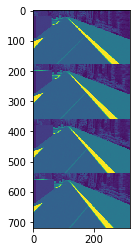

In [8]:
# making sure things are cool and good
plt.imshow(img_sets[19][0][0])
plt.show
print(len(img_sets))
print(labels[img_sets[124][0][1]])

In [5]:
all_dataset = np.concatenate(img_sets, axis=0)
np.random.shuffle(all_dataset)

In [6]:
X_dataset_orig = np.array([data[0] for data in all_dataset[:]])
Y_dataset_orig = np.array([[data[1]] for data in all_dataset]).T

NUMBER_OF_LABELS = 6
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
  
# Normalize X (images) dataset
X_dataset = X_dataset_orig/255.

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(Y_dataset_orig, NUMBER_OF_LABELS).T

In [7]:
n, h, w = X_dataset.shape
X_dataset = X_dataset.reshape(n, h, w, 1)
print(X_dataset.shape)

(5918, 720, 320, 1)


In [8]:
VALIDATION_SPLIT = 0.2

print("Total examples: {}\nTraining examples: {}\nTest examples: {}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 5918
Training examples: 4735.0
Test examples: 1183.0
X shape: (5918, 720, 320, 1)
Y shape: (5918, 6)


In [9]:
# model setup 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [10]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [11]:
# input_shape needs to match the input, duh
conv_model = models.Sequential()
# this creates our convolution kernel, (3,3) is the size of it
conv_model.add(layers.Conv2D(12, (5, 5), activation='relu',
                             input_shape=(180*4, 320, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(12, (5, 5), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(24, (5, 5), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(6*12, activation='relu'))
conv_model.add(layers.Dense(6, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 716, 316, 24)      624       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 358, 158, 24)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 354, 154, 24)      14424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 177, 77, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 173, 73, 24)       14424     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 86, 36, 24)        0         
_________________________________________________________________
flatten (Flatten)            (None, 74304)             0

In [13]:
reset_weights(conv_model)

In [14]:
lr= 5e-4
config = wandb.config
config.learning_rate = lr

conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=lr),
                   metrics=['acc'])

In [15]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=5, 
                              batch_size=100,
                              callbacks=[WandbCallback()])

Train on 4734 samples, validate on 1184 samples
Epoch 1/5
4734/4734 [==============================] - 900s 190ms/sample - loss: 0.7350 - acc: 0.7907 - val_loss: 0.6712 - val_acc: 0.7897
Epoch 2/5
4734/4734 [==============================] - 890s 188ms/sample - loss: 0.2909 - acc: 0.9113 - val_loss: 0.3790 - val_acc: 0.8674
Epoch 3/5
4734/4734 [==============================] - 887s 187ms/sample - loss: 0.2477 - acc: 0.9265 - val_loss: 0.3197 - val_acc: 0.9088
Epoch 4/5
4734/4734 [==============================] - 859s 181ms/sample - loss: 0.2294 - acc: 0.9286 - val_loss: 0.2933 - val_acc: 0.9046
Epoch 5/5
4734/4734 [==============================] - 865s 183ms/sample - loss: 0.2010 - acc: 0.9371 - val_loss: 0.3627 - val_acc: 0.8961


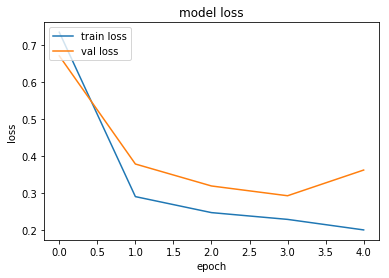

In [16]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

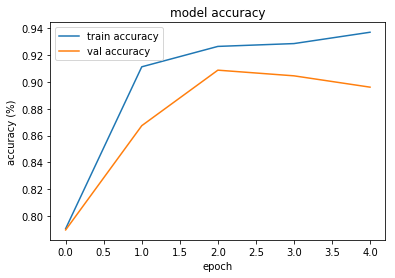

In [17]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [18]:
tf.keras.models.save_model(conv_model, "/home/andrew/ros_ws/src/2020T1_competition/controller/OL")